In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots an event-level variable (in this case, MET, but switching it is as easy as a dict-key change). It also demonstrates an easy use of the book-keeping cutflow tool, to keep track of the number of events processed.

# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class Processor(processor.ProcessorABC):
    def __init__(self):
        # Bins and categories for the histogram are defined here. For format, see https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html && https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Bin.html
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET", "MET [GeV]", 50, 0, 100)
        
        # The accumulator keeps our data chunks together for histogramming. It also gives us cutflow, which can be used to keep track of data.
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        # This is where we do our actual analysis. The dataset has columns similar to the TTree's; events.columns can tell you them, or events.[object].columns for deeper depth.
        dataset = events.metadata["dataset"]
        MET = events.MET.pt
        
        # We can define a new key for cutflow (in this case 'all events'). Then we can put values into it. We need += because it's per-chunk (demonstrated below)
        output['cutflow']['all events'] += MET.size
        output['cutflow']['number of chunks'] += 1
        
        # This fills our histogram once our data is collected. The hist key ('MET=') will be defined in the bin in __init__.
        output['MET'].fill(dataset=dataset, MET=MET.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

from dask.distributed import Client
from coffea_casa import CoffeaCasaCluster

cluster = CoffeaCasaCluster()
cluster.adapt(minimum=4, maximum=16)
client = Client(cluster)

output = processor.run_uproot_job(fileset=fileset, 
                       treename="Events", 
                       processor_instance=Processor(),
                       executor=processor.dask_executor,
                       executor_args={'client': client, 'nano': True},
                       chunksize=250000)

{'protocol': 'tls://', 'security': Security(require_encryption=True, tls_ca_file='/etc/cmsaf-secrets/ca.pem', tls_client_cert='/etc/cmsaf-secrets/hostcert.pem', tls_client_key='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_cert='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_key='/etc/cmsaf-secrets/hostcert.pem', tls_worker_cert='/etc/cmsaf-secrets/hostcert.pem', tls_worker_key='/etc/cmsaf-secrets/hostcert.pem'), 'log_directory': 'logs', 'silence_logs': 'DEBUG', 'scheduler_options': {'port': 8786, 'dashboard_address': '8787', 'protocol': 'tls', 'external_address': 'tls://matousadamec-40gmail-2ecom.dask.coffea.casa:8786'}, 'job_extra': {'universe': 'docker', 'docker_image': 'coffeateam/coffea-casa-analysis:0.2.23', 'container_service_names': 'dask', 'dask_container_port': 8786, 'transfer_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/cmsaf-secrets/xcache_token', 'encrypt_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/c

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tls://192.168.145.131:8786
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-6d38b79f-f2c1-11ea-8722-ae5d2030f5f0
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed |  3.0s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.206:32775', name: htcondor--7504805.0--, memory: 0, processing: 1>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.206:32775
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed |  5.1s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32843', name: htcondor--7504804.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32843
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed |  7.6s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.91:32795', name: htcondor--7504807.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.91:32795
distributed.core - INFO - Starting established connection


[###                                     ] | 8% Completed |  9.6s3s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32844', name: htcondor--7504808.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32844
distributed.core - INFO - Starting established connection


[#################                       ] | 44% Completed | 28.1s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.206:32776', name: htcondor--7504811.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.206:32776
distributed.core - INFO - Starting established connection


[####################                    ] | 51% Completed | 31.4s

distributed.scheduler - INFO - Register worker <Worker 'tls://129.93.182.3:32845', name: htcondor--7504809.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://129.93.182.3:32845
distributed.core - INFO - Starting established connection


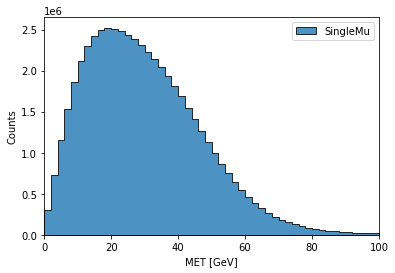

In [4]:
# Generates a 1D histogram from the data output to the 'MET' key. fill_opts are optional, to fill the graph (default is a line).
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
# Easy way to print all cutflow dict values. Can just do print(output['cutflow']["KEY_NAME"]) for one.
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of chunks 214
